In [3]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import kstest, anderson
import math
import seaborn as sns; sns.set()
import progressbar as pb
import time 
from scipy.sparse import csgraph

In [4]:
# read csv/excel data files 
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')
pnas_data2 = pd.read_csv('/home/jaeweon/research/data/pnas_data2.csv')
raw = pd.read_excel('/home/jaeweon/research/data/raw.xlsx', encoding = 'ISO-8859-1')
raw_corrected = pd.read_csv('/home/jaeweon/research/data/seshat_corrected.csv', encoding = 'ISO-8859-1')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = pnas_data1.loc[:, features].values
scaled = StandardScaler().fit_transform(data_mat)

In [256]:
# class for progressbar
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter = n_iter
        self.iter = 0
        self.description = description + ': '
        self.timer = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()


In [257]:
# Check if XX^T, where X is the data matrix, is positive semidefinite 

def is_pos_def(x):
    """
    Check if the matrix is positive semidefinite 
    """
    return np.all(np.linalg.eigvals(x) > 0)

transposed = np.transpose(data_mat)
sym_mat = np.matmul(data_mat, transposed)
assert is_pos_def(sym_mat) == True # false -> is not positive semidefinite 

AssertionError: 

In [6]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

In [7]:
def pca(data, num_components):
    """
    perform PCA on the given data matrix
    """
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components= num_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    variance = pca.explained_variance_
    X_new = pca.inverse_transform(X_pca)
    return X_new, variance

In [14]:
# SVD on the original data matrix. 
filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)

P, D, Q = svd(filtered_pnas1)
reconstruct = np.matmul(np.matmul(P, np.diag(D)), Q)
print(np.std(filtered_pnas1), np.std(reconstruct), np.std(filtered_pnas1-reconstruct))
print(Q.T[:,0])

1.0 1.0 1.47612302175e-15
[ 0.35184449  0.32197153  0.33691204  0.34112479  0.33297665  0.33286962
  0.32848139  0.34938387  0.3016939 ]


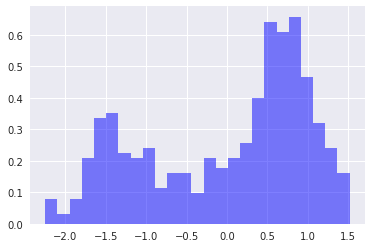

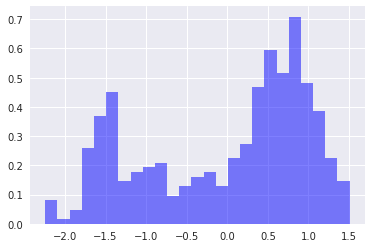

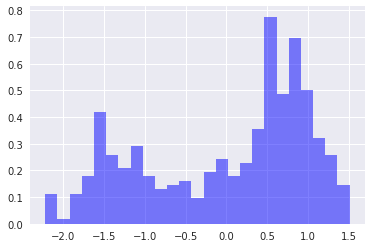

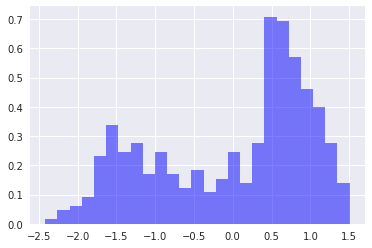

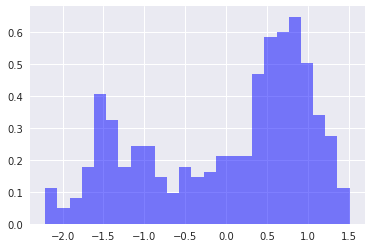

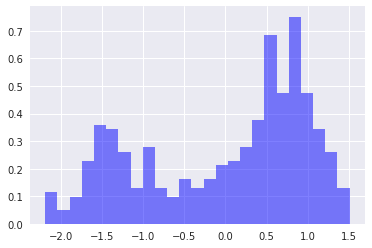

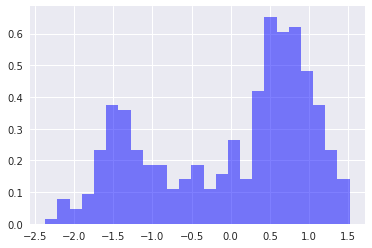

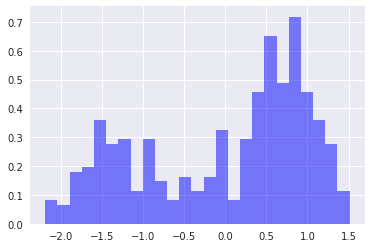

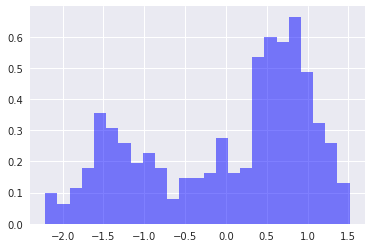

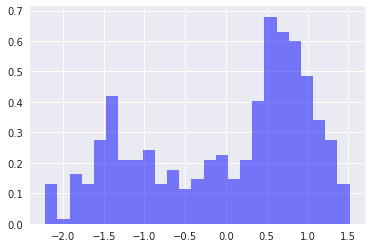

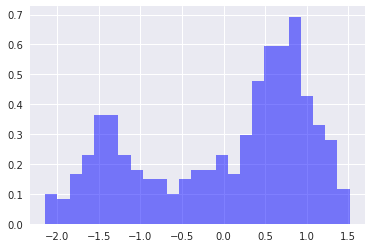

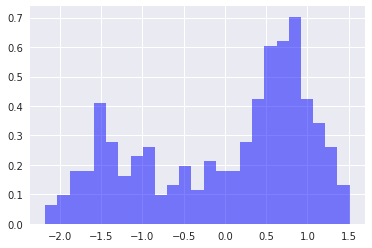

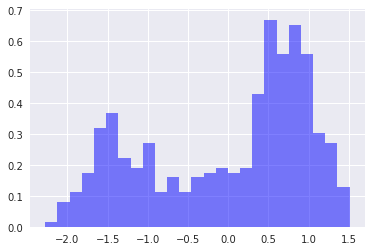

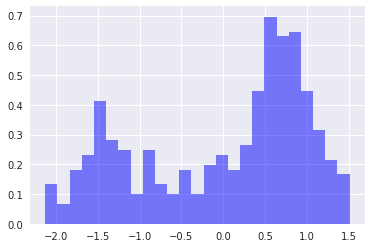

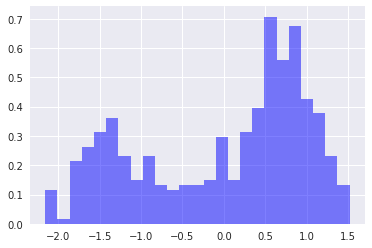

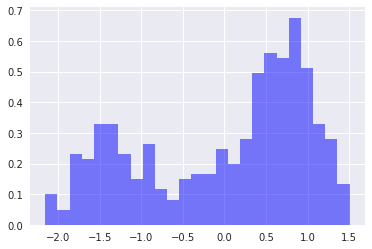

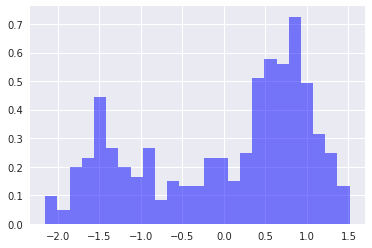

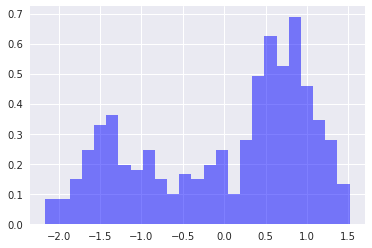

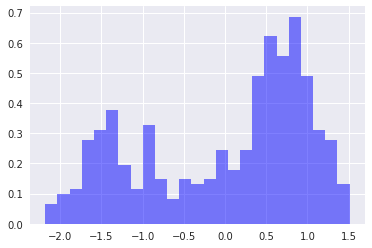

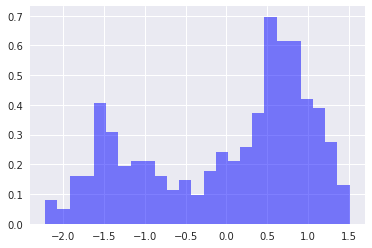

In [436]:
# histogram based on pca values 
impute = ['V'+str(i) for i in range(1, 21)]

for i in impute:
    data = StandardScaler().fit_transform(pnas_data2.loc[:, [i]].values)
    # filtered_pnas1 = pnas_data1.loc[:, features].values
    num_bins = 25

    #fit GMM
    gmm = GMM(n_components=2)
    gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

    # Evaluate GMM
    gmm_x = np.linspace(-6, 6, 200)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

    # the histogram/gaussian mixture model of the data
    n, bins, patches = plt.hist(data, num_bins, normed=1, facecolor='blue', alpha=0.5)

    plt.legend()
    plt.show()
    plt.close()


In [555]:
# covariance and check for orthonormality

filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
P, D, Q = svd(filtered_pnas1)

product = np.dot(Q.T,Q)
np.fill_diagonal(product,0)
if (product.any() == 0): 
    raise Exception('not orthogonal') #check orthogonality of the matrix to ensure that PCs are orthogonal

D = [x**2/sum([y**2 for y in D]) for x in D] # variance for each vector 
data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix
num_bins = 100
mu = 0 # mean (data is centered)

# covariance matrix 
print(np.cov(Q.T))
X = data[:,0]; Y = data[:,1]
X = np.stack((X, Y), axis=0)
print("Covariance matrix for the first two components: ", np.cov(X))
print("Covariance matrix for the entire dataset: ", np.cov(data, rowvar= False))


[[ 0.1121876  -0.00773236  0.02070871  0.0079736   0.00165385 -0.00492465
   0.01463674 -0.00203276  0.02529468]
 [-0.00773236  0.12033348  0.01249782  0.00481211  0.00099811 -0.00297205
   0.00883335 -0.00122678  0.01526548]
 [ 0.02070871  0.01249782  0.09152849 -0.01288774 -0.00267311  0.00795972
  -0.02365738  0.00328555 -0.04088383]
 [ 0.0079736   0.00481211 -0.01288774  0.12003775 -0.00102925  0.00306478
  -0.00910895  0.00126506 -0.01574175]
 [ 0.00165385  0.00099811 -0.00267311 -0.00102925  0.12478652  0.00063568
  -0.00188933  0.00026239 -0.00326508]
 [-0.00492465 -0.00297205  0.00795972  0.00306478  0.00063568  0.12310713
   0.00562586 -0.00078132  0.00972241]
 [ 0.01463674  0.00883335 -0.02365738 -0.00910895 -0.00188933  0.00562586
   0.10827916  0.0023222  -0.02889635]
 [-0.00203276 -0.00122678  0.00328555  0.00126506  0.00026239 -0.00078132
   0.0023222   0.12467749  0.00401315]
 [ 0.02529468  0.01526548 -0.04088383 -0.01574175 -0.00326508  0.00972241
  -0.02889635  0.00401

In [337]:
filtered_pnas1 = (pnas_data1[pnas_data1.irep == 1].loc[:, features].values)
# filtered_pnas1 = pnas_data1.loc[:, features].values
P, D, Q = svd(filtered_pnas1)

data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix
idx_data = sorted(range(len(data[:,0])), key = lambda i: data[:,0][i])
re_idx = pnas_data1.reindex(idx_data)

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

impute1 = re_idx.loc[re_idx.irep==1]
impute1_idx = impute1.index.values
prob_distr = gmm.predict_proba(X=np.expand_dims(sorted(data[:,0]), 1))

rank = re_idx.loc[:, ['NGA', 'PolID', 'Time']]

if gmm.weights_[0] < gmm.weights_[1]:
    gauss1 = [i for i, j in prob_distr]
    gauss2 = [j for i, j in prob_distr]
else:
    gauss1 = [j for i, j in prob_distr]
    gauss2 = [i for i, j in prob_distr]
    
rank['Gauss1'] = pd.Series(gauss1, index = rank.index)
rank['Gauss2'] = pd.Series(gauss2, index = rank.index)

rank.to_csv('ranked_polity.csv')

In [338]:
# covariance and mean for GMM model 

filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
# filtered_pnas1 = pnas_data1.loc[:, features].values
P, D, Q = svd(filtered_pnas1)

D = [x**2/sum([y**2 for y in D]) for x in D] # variance for each vector 
data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

# retrive 25 polities from the lowest and the highest in the two Gaussian distrubitons 
# from the first principal component
subset_features = ['NGA', 'PolID', 'Time']

idx_data = sorted(range(len(data[:,0])), key = lambda i: data[:,0][i])
re_idx = pnas_data1.reindex(idx_data)
unique = re_idx.drop_duplicates(subset = subset_features) #drop duplicates from imputation

#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# Evaluate GMM
gmm_x = np.linspace(-6, 6, 200)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# mean and covariance for each component
gauss_one = gmm.weights_[0] #weight for gaussian distribution
gauss_two = gmm.weights_[1] #weight for gaussian distribution 

prob_distr = gmm.predict_proba(X=np.expand_dims(sorted(data[:,0]), 1))
lower = list()
higher = list()

# compute which datapoints belong in the lower and higher gaussian
for idx in range(len(prob_distr)):
    if gmm.weights_[0] < gmm.weights_[1]:
        if prob_distr[idx][0] >= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])
    else:
        if prob_distr[idx][0] <= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])

lower = [i for i in unique.index.values for j in lower if i==j]
higher = [i for i in unique.index.values for j in higher if i==j]

gauss1_pol = pnas_data1.loc[lower[-25:]].loc[:, subset_features]
gauss2_pol = pnas_data1.loc[higher[:25]].loc[:, subset_features]

#indicate the origin of each row 
gauss1_pol['origin'] = 'Gauss1'
gauss2_pol['origin'] = 'Gauss2'

#transition 
trans = gauss1_pol.append(gauss2_pol).sort_values(by=['NGA', 'Time'])
# trans.to_csv('transition.csv')

# return polities that lie in both Gaussians
lower_df = unique.loc[lower]
higher_df = unique.loc[higher]
unique_pol = [i for i in unique.PolID.unique().tolist() if (i in lower_df.PolID.unique().tolist() 
                                                            and i in higher_df.PolID.unique().tolist())]


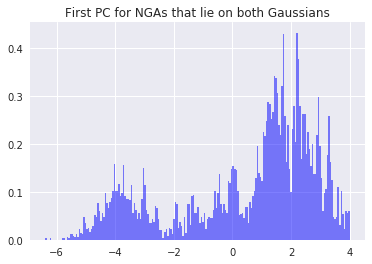

In [300]:
# compute which datapoints belong in the lower and higher gaussian
for idx in range(len(prob_distr)):
    if gmm.weights_[0] < gmm.weights_[1]:
        if prob_distr[idx][0] >= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])
    else:
        if prob_distr[idx][0] <= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])

lower = [i for i in unique.index.values for j in lower if i==j]
higher = [i for i in unique.index.values for j in higher if i==j]

gauss1_pol = pnas_data1.loc[lower[-25:]].loc[:, subset_features]
gauss2_pol = pnas_data1.loc[higher[:25]].loc[:, subset_features]

#indicate the origin of each row 
gauss1_pol['origin'] = 'Gauss1'
gauss2_pol['origin'] = 'Gauss2'

#transition 
trans = gauss1_pol.append(gauss2_pol).sort_values(by=['NGA', 'Time'])
# trans.to_csv('transition.csv')

# return polities that lie in both Gaussians
lower_df = unique.loc[lower]
higher_df = unique.loc[higher]
unique_pol = [i for i in unique.PolID.unique().tolist() if (i in lower_df.PolID.unique().tolist() 
                                                            and i in higher_df.PolID.unique().tolist())]
unique_nga = [i for i in unique.NGA.unique().tolist() if (i in lower_df.NGA.unique().tolist()
                                                         and i in higher_df.NGA.unique().tolist())]


nga_gauss = pnas_data1.loc[pnas_data1['NGA'].isin(unique_nga)]
both_gauss = np.take(data[:,0], nga_gauss.index.values)
num_bins = 200

n, bins, patches = plt.hist(both_gauss, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('First PC for NGAs that lie on both Gaussians')
plt.legend()
plt.show()
plt.close()


In [ ]:
# comparison between the main principal axis from univariate Gaussian with two principal axes from 
# bivariate Gaussian

data_mat = pnas_data1.loc[:, features].values

# univariate Gaussian
gmm1 = GMM(n_components=1).fit(data_mat)
cov = gmm1.covariances_[0]

# bivariate Gaussian
gmm2 = GMM(n_components=2).fit(data_mat)
cov_comp1 = gmm2.covariances_[0]
cov_comp2 = gmm2.covariances_[1]

# eigenvectors for the covariance matrices
eig_val1, eig_vec1 = np.linalg.eigh(cov)
eig_val_comp1, eig_vec_comp1 = np.linalg.eigh(cov_comp1)
eig_val_comp2, eig_vec_comp2 = np.linalg.eigh(cov_comp2)

def main_axis(eig_val, eig_vec):
    """
    Given eigenvalues and corresponding eigenvectors, find the principal axis (i.e. eigenvectors that correspond
    to the largest eigenvalue). Return the eigenvector that represents the principal axis as well as the 
    percentage representation of the corresponding eigenvalue
    """
    idx = eig_val.tolist().index(max(eig_val))
    main_vec = eig_vec[:,idx]
    main_eig = eig_val[idx]/sum(eig_val)
    return main_eig, main_vec

gmm1_eig, gmm1_axis = main_axis(eig_val1, eig_vec1)
gmm2_eig_comp1, gmm2_axis_comp1 = main_axis(eig_val_comp1, eig_vec_comp1)
gmm2_eig_comp2, gmm2_axis_comp2 = main_axis(eig_val_comp2, eig_vec_comp2)

def angle(vec1, vec2):
    """
    Given two vectors, compute the angle between the vectors
    """
    assert vec1.shape == vec2.shape
    
    cos_vec = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    angle = math.acos(cos_vec)
    in_deg = math.degrees(angle)
    if in_deg >= 90:
        return (180-in_deg)
    return in_deg

print(gmm2_axis_comp1, gmm2_axis_comp2)
gmm2 = angle(gmm2_axis_comp1, gmm2_axis_comp2)
comp1 = angle(gmm1_axis, gmm2_axis_comp1)
comp2 = angle(gmm1_axis, gmm2_axis_comp2)

print("percentage representation of univariate Gaussian eigenvalue: ", gmm1_eig*100, '%')
print("percentage representation of the first component of bivariate Gaussian eigenvalue: ", gmm2_eig_comp1*100, '%')
print("percentage representation of the first component of bivariate Gaussian eigenvalue: ", gmm2_eig_comp2*100, "%\n")

print("angle between two components of bivariate Gaussian : ", gmm2)
print("angle between main axis and first component of bivariate Gaussian : ", comp1)
print("angle between main axis and second component of bivariate Gaussian : ", comp2)

    

In [508]:
#20 imputed sets combined
X = pnas_data1.loc[:, features].values
X = StandardScaler().fit_transform(X)
P, D, Q = svd(X)
pca = PCA(n_components=9)
pca.fit(X)
X_pca = pca.transform(X)
X_new = pca.inverse_transform(X_pca)

print("components matrix : ", pca.components_, "\n")
print("variance : ", pca.explained_variance_, "\n")
print("singular values : ", pca.singular_values_, "\n")

print('singular value matrix', D)
print('column mat', Q)



components matrix :  [[-0.35184449 -0.32197153 -0.33691204 -0.34112479 -0.33297665 -0.33286962
  -0.32848139 -0.34938387 -0.3016939 ]
 [-0.33885801 -0.47466313 -0.37363756 -0.20478612  0.12918721  0.16850614
   0.42336133  0.32350207  0.38646567]
 [ 0.1238707   0.3177609  -0.09256578 -0.05839083 -0.46790073 -0.47255936
   0.13114705 -0.05112575  0.64003852]
 [-0.01439807 -0.34044785  0.14428373  0.21732156  0.11141488  0.25005825
  -0.55642333 -0.33309761  0.56598424]
 [-0.04629945  0.41527587 -0.59961256  0.03693777  0.6181868  -0.16061037
  -0.18502999 -0.1257437   0.08065053]
 [ 0.17002253  0.29532094 -0.01593358 -0.75887495 -0.08723973  0.51545042
  -0.15627264 -0.03040533  0.09532722]
 [ 0.12775423 -0.21179927  0.46073737 -0.4536754   0.49961207 -0.47512205
   0.1278661  -0.14931267  0.08199045]
 [-0.77555646  0.34680388  0.37040678 -0.0437141   0.0403597  -0.05254957
  -0.21367566  0.28614715  0.08484874]
 [-0.31139876  0.1713247   0.09071833  0.0779134   0.00927566  0.23446699
 

In [23]:
#try PCA for each imputed dataset. Result was roughly the same across all 20 imputed dataset
for i in range(20):
    imputed_set = pnas_data1[pnas_data1.irep == (i+1)]
    X = imputed_set.loc[:, features].values
    
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=9)
    pca.fit(X)
    print(str(i+1) + 'th imputed set', pca.explained_variance_)


1th imputed set [ 6.95456595  0.53898619  0.41781449  0.33829053  0.23192585  0.20515738
  0.15098684  0.10225482  0.08180972]
2th imputed set [ 6.99857018  0.51004731  0.41538579  0.35553494  0.22283908  0.20418307
  0.1531763   0.08624197  0.07581313]
3th imputed set [ 6.97692367  0.54300461  0.41921652  0.34468072  0.21844017  0.20236374
  0.15774642  0.08517682  0.0742391 ]
4th imputed set [ 6.9711295   0.55692525  0.42193305  0.34617265  0.2133972   0.20131161
  0.15126108  0.09177529  0.06788614]
5th imputed set [ 6.94239471  0.56425187  0.41822403  0.33146201  0.2318954   0.21130869
  0.15477703  0.09264955  0.07482847]
6th imputed set [ 6.96897315  0.52416112  0.41538604  0.35202733  0.21803114  0.20760835
  0.16552746  0.09392112  0.07615607]
7th imputed set [ 6.9648173   0.57198529  0.40864104  0.34103006  0.21854222  0.20051266
  0.14324606  0.09273841  0.08027871]
8th imputed set [ 6.99231885  0.51106865  0.42915113  0.34048573  0.22857671  0.20521261
  0.15277528  0.087487

[[-0.35184449 -0.32197153 -0.33691204 -0.34112479 -0.33297665 -0.33286962
  -0.32848139 -0.34938387 -0.3016939 ]
 [-0.33885801 -0.47466313 -0.37363756 -0.20478612  0.12918721  0.16850614
   0.42336133  0.32350207  0.38646567]]
[-2.78272367 -2.54645969] [  4.29286236e-16   3.29097994e-16]
[-0.7454357  -1.04418615] [  4.29286236e-16   3.29097994e-16]


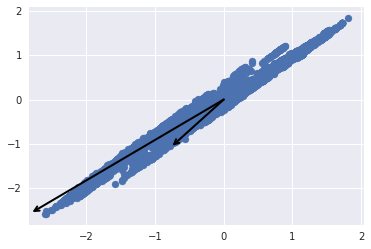

In [541]:
# plot 3d scatter plot by using 3 PCs

#draw vectors of principal component axis 
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    print(v1, v0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

X = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_new = pca.inverse_transform(X_pca)

# P, D, Q = svd(filtered_pnas1)
# data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

plt.scatter(X_new[:, 0], X_new[:, 1])
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector  * 3 * np.sqrt(length)
    draw_vector(pca.mean_[:2], (pca.mean_ + v)[:2])
plt.show()
plt.close()

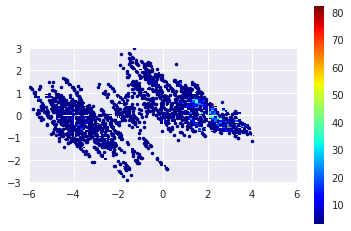

In [26]:
# Plotting projection for two components as 2-d scatter plot 

#histogram definition
xyrange = [[-6,6],[-3,3]] # data range
bins = [100,100] # number of bins
thresh = 3  #density threshold

#data definition
N = 1e5;
# plot 3d scatter plot by using 3 PCs

#normality test 
filtered_pnas1 = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
P, D, Q = svd(filtered_pnas1)

data = np.matmul(filtered_pnas1, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

fig = plt.figure()
X, Y = data[:, 0], data[:, 1]

# histogram the data
hh, locx, locy = scipy.histogram2d(X, Y, range=xyrange, bins=bins)
posx = np.digitize(X, locx)
posy = np.digitize(Y, locy)

#select points within the histogram
ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
xdat1 = X[ind][hhsub < thresh] # low density points
ydat1 = Y[ind][hhsub < thresh]
hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')
plt.colorbar()   
plt.plot(xdat1, ydat1, '.',color='darkblue')
plt.show()

In [131]:
# list of split dataset based on timeframe as well as the entire dataset 
#(5 stages : ~-1500, -1500~0, 0~1000, 1000~1500, 1500~)

stage1 = pnas_data1.loc[pnas_data1['Time'] < -1500]
stage2 = pnas_data1.loc[(pnas_data1['Time'] < 0) & (pnas_data1['Time'] >= -1500)]
stage3 = pnas_data1.loc[(pnas_data1['Time'] < 1000) & (pnas_data1['Time'] >= 0)] 
stage4 = pnas_data1.loc[(pnas_data1['Time'] < 1500) & (pnas_data1['Time'] >= 1000)]
stage5 = pnas_data1.loc[pnas_data1['Time'] > 1500]

stages = [stage1, stage2, stage3, stage4, stage5, pnas_data1]

for i in range(6):
    stages[i] = stages[i].loc[:,features].values
    
    P, D, Q = svd(stages[i])
#     print("This is the " + str(i)+"th stage")
#     print("Singular values : ", D)
#     print("column vectors from SVD : ", Q[:,0])
    print('Q', Q)
    col_vec = np.abs(Q)
    col_vec = col_vec/sum(col_vec)*100
    print('col_vec', col_vec)
    break
    D = D/sum(D)*100  # percentage of singular values 
    stages[i] = [D, Q[:,0], col_vec[:,0]]
    


Q [[  4.89385612e-01   4.49640632e-01   3.23119140e-01   4.26346583e-01
    8.53371963e-02   8.15461018e-02   8.85622748e-02   1.18724690e-01
    4.86082920e-01]
 [ -2.51846886e-01  -3.97197061e-01  -1.86454588e-01  -1.28793298e-01
   -1.06927766e-02   7.15830286e-04   2.19596515e-02   1.30298601e-02
    8.52459830e-01]
 [  4.44025186e-02   6.58232200e-01  -2.81774557e-01  -6.69535773e-01
   -7.19820127e-02  -7.51653807e-02  -5.23953235e-03  -3.99570083e-02
    1.56934624e-01]
 [ -5.07771808e-01   3.86904252e-01  -5.14739685e-01   5.69755399e-01
    2.81916916e-03  -5.34621385e-02  -2.03475416e-03   3.11336388e-03
    3.84078440e-03]
 [  6.52877881e-01  -2.34145571e-01  -7.10933369e-01   9.80790899e-02
    2.01690453e-02  -8.99332811e-03   1.13336527e-02  -5.81595454e-03
   -5.68384924e-02]
 [  9.83369588e-02   1.60622651e-02   8.59828816e-02   1.26271367e-01
   -3.47863016e-01  -3.29372889e-01  -5.40272831e-01  -6.60638059e-01
    9.43492293e-02]
 [ -3.35315468e-02   4.01528850e-02  -

In [38]:
# diffusion map for the data matrix

data_mat = pnas_data1[pnas_data1.irep == 1].loc[:, features].values

#center the data
mean = np.mean(data_mat, axis=0)
data_mat -= mean

def sim(a,b):
    """
    Given two n-dim vectors a,b, compute the similarity as given by the euclidean norm distance 
    """
    return np.linalg.norm(a-b)


def adj(mat):
    """
    Compute the directed adjacency matrix using similarity function between two vectors
    """
    adj_mat = np.zeros((data_mat.shape[0], data_mat.shape[0]))

    for i in range(data_mat.shape[0]):

        sim_list = list()
        for j in range(data_mat.shape[0]):
            if i != j:
                sim_list.append(sim(data_mat[i], data_mat[j]))
        most_sim = np.argsort(sim_list)[:10] # top 10 vectors that are similar to one another 

        for k in range(len(most_sim)):
            adj_mat[i][most_sim[k]] = sim_list[k]
        
    return adj_mat

def laplacian(mat):
    """
    Given an adjacency matrix of a directed graph, compute the laplacian matrix 
    """
    return csgraph.laplacian(mat)

def job():
    adj_mat = adj(data_mat)
    lap_mat = laplacian(adj_mat)
#     print(lap_mat[:, :2])
    eig_val, eig_vec = np.linalg.eig(lap_mat)
        
    print((eig_vec[313]))

job()

    

    
    
        

[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j  -6.97876452e-06 +0.00000000e+00j
   3.25219862e-07 +0.00000000e+00j  -9.38340505e-07 -9.41333832e-08j
  -9.38340505e-07 +9.41333832e-08j   3.38674441e-05 +0.00000000e+00j
   7.67961548e-06 -1.37159709e-06j   7.67961548e-06 +1.37159709e-06j
   2.21915606e-05 -1.06359865e-05j   2.21915606e-05 +1.06359865e-05j
  -1.31731609e-05 +0.00000000e+00j  -2.98520132e-06 +5.94878385e-07j
  -2.98520132e-06 -5.94878385e-07j  -5.53890213e-06 +0.00000000e+00j
  -6.42168963e-07 +0.00000000e+00j  -1.60293232e-05 -1.41656934e-05j
  -1.60293232e-05 +1.41656934e-05j   2.50533159e-05 +6.22288338e-06j
   2.50533159e-05 -6.22288338e-06j  -5.18843383e-06 -7.16844621e-06j
  -5.18843383e-06 +7.16844621e-06j